<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_2_Convolution_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import os

from itertools import islice
import seaborn as sns

# Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/guava-disease-dataset


In [3]:
ds_folder = path+"/GuavaDiseaseDataset/GuavaDiseaseDataset/"

In [4]:
img_size = (224, 224)
img_channels = 3
batch_size = 64
lr = 1e-3

# Datasets and DataLoaders

In [5]:
train_dataset = ImageFolder(root=ds_folder + "train/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.RandomHorizontalFlip(0.5),
                                T.RandomVerticalFlip(0.5),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [6]:
test_dataset = ImageFolder(root=ds_folder + "test/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [7]:
val_dataset = ImageFolder(root=ds_folder + "val/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [8]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset) // 10, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
os.makedirs("Models", exist_ok=True)

# Training Functins

In [10]:
def train_step(model, data_loader, criterion, optimizer, scheduler):

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Training")
  total_loss = 0.0
  total_correct = 0.0

  model.train()

  for image, label in progress_bar:
    images, labels = image.cuda(), label.cuda()

    optimizer.zero_grad()

    predictions = model(images)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_classes = torch.sum(predicted_classes == labels)
    loss = criterion(predictions, labels)

    total_correct += correct_classes.item()
    total_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
    optimizer.step()
  scheduler.step(loss.item())

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [11]:
def evaluate(model, data_loader, criterion):

  model.eval()

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Evaluating")
  total_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    for image, label in progress_bar:
      images, labels = image.cuda(), label.cuda()

      predictions = model(images)
      predicted_classes = torch.argmax(predictions, dim=1)
      correct_classes = torch.sum(predicted_classes == labels)
      loss = criterion(predictions, labels)

      total_correct += correct_classes.item()
      total_loss += loss.item()

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [12]:
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs, experiment_name):

  df = pd.DataFrame(np.empty([epochs, 5]),
                    index=np.arange(epochs),
                    columns=["Train_Loss", "Train_Acc", "Val_Loss", "Val_Acc", "lr"])

  highest_acc = 0.00

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    df.iloc[epoch, 0], df.iloc[epoch, 1] = train_step(model=model, data_loader=train_dataloader,
                                            criterion=criterion, optimizer=optimizer,
                                            scheduler=scheduler)

    df.iloc[epoch, 2], df.iloc[epoch, 3] = evaluate(model=model, data_loader=val_dataloader,
                                            criterion=criterion)

    df.iloc[epoch, 4] = optimizer.param_groups[0]["lr"]

    print(f"Training Loss = {df.iloc[epoch, 0]:.7f}, Training Accuracy = {df.iloc[epoch, 1]:.3f}\nTesting Loss = {df.iloc[epoch, 2]:.7f}, Testing Accuracy = {df.iloc[epoch, 3]:.3f}")


    if df.iloc[epoch, 3] > highest_acc:
      torch.save(model.state_dict(), f"Models/{experiment_name}.pth")
      highest_acc = df.iloc[epoch, 3]
      print(f"New best accuracy: {highest_acc:.3f} at epoch {epoch+1}")

    print("*"*50)
    print("")

  return df

# FC Neural Network

In [13]:
class FC_Model(nn.Module):
  def __init__(self, skeleton:list, num_classes):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.Dropout1d(0.5))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], num_classes))
    self.model = nn.Sequential(*layer_list)

  def forward(self, images):
    inputs = images.view(images.shape[0], -1)
    output = self.model(inputs)
    return output

In [14]:
model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 100, 50, 20], num_classes=3).cuda()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [16]:
fc_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="fully_connected")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Training Loss = 0.0174216, Training Accuracy = 33.094
Testing Loss = 0.0160125, Testing Accuracy = 58.808
New best accuracy: 58.808 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0163182, Training Accuracy = 41.292
Testing Loss = 0.0151923, Testing Accuracy = 69.404
New best accuracy: 69.404 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Training Loss = 0.0162822, Training Accuracy = 45.372
Testing Loss = 0.0152978, Testing Accuracy = 69.404
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0165432, Training Accuracy = 45.032
Testing Loss = 0.0148678, Testing Accuracy = 73.642
New best accuracy: 73.642 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Training Loss = 0.0162492, Training Accuracy = 45.637
Testing Loss = 0.0144051, Testing Accuracy = 74.437
New best accuracy: 74.437 at epoch 5
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0161394, Training Accuracy = 45.712
Testing Loss = 0.0145697, Testing Accuracy = 76.556
New best accuracy: 76.556 at epoch 6
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0162033, Training Accuracy = 45.561
Testing Loss = 0.0147118, Testing Accuracy = 73.907
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Training Loss = 0.0162325, Training Accuracy = 45.259
Testing Loss = 0.0145381, Testing Accuracy = 75.762
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0161887, Training Accuracy = 45.032
Testing Loss = 0.0143383, Testing Accuracy = 74.305
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Training Loss = 0.0161202, Training Accuracy = 44.617
Testing Loss = 0.0141436, Testing Accuracy = 75.364
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Training Loss = 0.0161802, Training Accuracy = 44.428
Testing Loss = 0.0141459, Testing Accuracy = 75.232
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Training Loss = 0.0160724, Training Accuracy = 45.297
Testing Loss = 0.0139795, Testing Accuracy = 76.556
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0158558, Training Accuracy = 45.372
Testing Loss = 0.0140646, Testing Accuracy = 77.086
New best accuracy: 77.086 at epoch 13
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Training Loss = 0.0157866, Training Accuracy = 47.148
Testing Loss = 0.0141758, Testing Accuracy = 75.232
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Training Loss = 0.0158269, Training Accuracy = 46.241
Testing Loss = 0.0140320, Testing Accuracy = 74.437
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0158432, Training Accuracy = 45.825
Testing Loss = 0.0140288, Testing Accuracy = 76.159
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0160870, Training Accuracy = 45.032
Testing Loss = 0.0138371, Testing Accuracy = 77.748
New best accuracy: 77.748 at epoch 17
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Training Loss = 0.0158841, Training Accuracy = 46.165
Testing Loss = 0.0139571, Testing Accuracy = 76.556
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0158083, Training Accuracy = 45.977
Testing Loss = 0.0135925, Testing Accuracy = 77.881
New best accuracy: 77.881 at epoch 19
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0158494, Training Accuracy = 45.561
Testing Loss = 0.0138555, Testing Accuracy = 77.219
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0156898, Training Accuracy = 47.185
Testing Loss = 0.0136015, Testing Accuracy = 78.013
New best accuracy: 78.013 at epoch 21
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0157321, Training Accuracy = 46.279
Testing Loss = 0.0136332, Testing Accuracy = 77.748
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Training Loss = 0.0156644, Training Accuracy = 46.165
Testing Loss = 0.0135946, Testing Accuracy = 78.543
New best accuracy: 78.543 at epoch 23
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0158138, Training Accuracy = 46.505
Testing Loss = 0.0134661, Testing Accuracy = 78.675
New best accuracy: 78.675 at epoch 24
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0157083, Training Accuracy = 46.921
Testing Loss = 0.0135491, Testing Accuracy = 78.146
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Training Loss = 0.0156175, Training Accuracy = 46.619
Testing Loss = 0.0134513, Testing Accuracy = 76.954
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Training Loss = 0.0157721, Training Accuracy = 46.430
Testing Loss = 0.0134456, Testing Accuracy = 78.146
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Training Loss = 0.0157978, Training Accuracy = 46.619
Testing Loss = 0.0134556, Testing Accuracy = 76.026
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Training Loss = 0.0156938, Training Accuracy = 47.185
Testing Loss = 0.0134435, Testing Accuracy = 77.086
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Training Loss = 0.0156146, Training Accuracy = 46.619
Testing Loss = 0.0134005, Testing Accuracy = 77.616
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0156597, Training Accuracy = 46.392
Testing Loss = 0.0135093, Testing Accuracy = 77.616
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0159502, Training Accuracy = 46.354
Testing Loss = 0.0134358, Testing Accuracy = 78.013
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0155980, Training Accuracy = 47.223
Testing Loss = 0.0133558, Testing Accuracy = 78.278
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0156857, Training Accuracy = 47.223
Testing Loss = 0.0136195, Testing Accuracy = 75.894
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0157667, Training Accuracy = 46.543
Testing Loss = 0.0134250, Testing Accuracy = 77.748
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0156301, Training Accuracy = 46.392
Testing Loss = 0.0131393, Testing Accuracy = 79.073
New best accuracy: 79.073 at epoch 36
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0157667, Training Accuracy = 46.619
Testing Loss = 0.0133252, Testing Accuracy = 76.821
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Training Loss = 0.0156094, Training Accuracy = 47.261
Testing Loss = 0.0136049, Testing Accuracy = 77.086
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Training Loss = 0.0156086, Training Accuracy = 47.223
Testing Loss = 0.0134168, Testing Accuracy = 78.278
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0157087, Training Accuracy = 46.808
Testing Loss = 0.0134819, Testing Accuracy = 76.689
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0155303, Training Accuracy = 46.770
Testing Loss = 0.0136135, Testing Accuracy = 75.762
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Training Loss = 0.0157025, Training Accuracy = 46.505
Testing Loss = 0.0131716, Testing Accuracy = 79.470
New best accuracy: 79.470 at epoch 42
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Training Loss = 0.0158031, Training Accuracy = 47.261
Testing Loss = 0.0132692, Testing Accuracy = 76.954
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Training Loss = 0.0158896, Training Accuracy = 46.581
Testing Loss = 0.0134955, Testing Accuracy = 77.881
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0156776, Training Accuracy = 47.450
Testing Loss = 0.0134729, Testing Accuracy = 76.026
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0156740, Training Accuracy = 47.148
Testing Loss = 0.0137380, Testing Accuracy = 77.748
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Training Loss = 0.0156667, Training Accuracy = 47.337
Testing Loss = 0.0134966, Testing Accuracy = 77.748
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Training Loss = 0.0157583, Training Accuracy = 47.148
Testing Loss = 0.0135673, Testing Accuracy = 76.291
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Training Loss = 0.0159686, Training Accuracy = 45.939
Testing Loss = 0.0134299, Testing Accuracy = 78.940
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

Training Loss = 0.0156949, Training Accuracy = 46.505
Testing Loss = 0.0134667, Testing Accuracy = 78.675
**************************************************



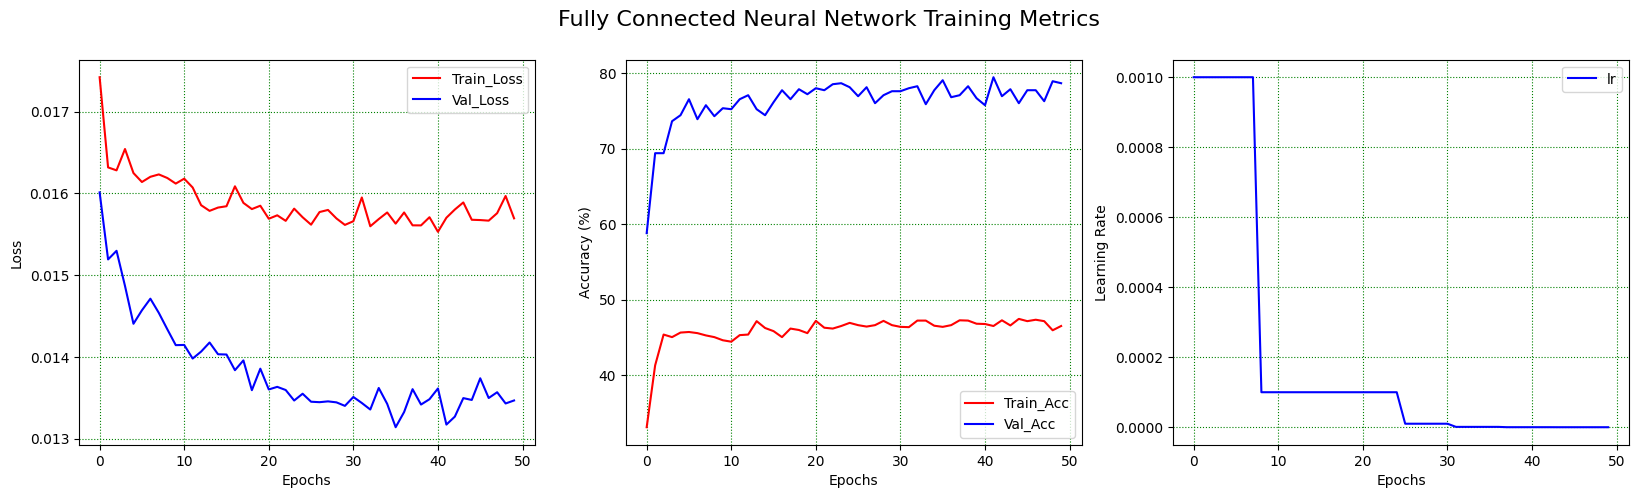

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

fc_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
fc_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
fc_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Fully Connected Neural Network Training Metrics', fontsize=16,)
plt.show()

# Custom CNN Layer - RESNet 9

In [18]:
def basic(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  )

In [19]:
class RS_block(nn.Module):
  def __init__(self, in_channels, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, in_channels),
        basic(in_channels, in_channels),
    )

  def forward(self, x):
    return x + self.net(x)

In [20]:
class ResNet9(nn.Module):

  def __init__(self, in_channels=img_channels, num_classes=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, 64),
        basic(64, 128), nn.MaxPool2d(2),
        RS_block(128),
        basic(128, 256), nn.MaxPool2d(2),
        basic(256, 512), nn.MaxPool2d(2),
        RS_block(512),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    output = self.net(x)
    return output

In [21]:
model = ResNet9().cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [22]:
my_cnn = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="my_cnn")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.3966377, Training Accuracy = 84.813
Testing Loss = 0.2470725, Testing Accuracy = 90.066
New best accuracy: 90.066 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Loss = 0.1519792, Training Accuracy = 94.333
Testing Loss = 0.0950496, Testing Accuracy = 96.159
New best accuracy: 96.159 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.1410633, Training Accuracy = 94.900
Testing Loss = 0.1823453, Testing Accuracy = 92.053
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.1095150, Training Accuracy = 95.807
Testing Loss = 1.4011889, Testing Accuracy = 61.722
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.0849650, Training Accuracy = 96.940
Testing Loss = 0.0574338, Testing Accuracy = 98.411
New best accuracy: 98.411 at epoch 5
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.0713235, Training Accuracy = 97.355
Testing Loss = 0.3503549, Testing Accuracy = 87.152
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0543419, Training Accuracy = 97.847
Testing Loss = 0.0983929, Testing Accuracy = 95.762
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.0496343, Training Accuracy = 98.300
Testing Loss = 0.0850741, Testing Accuracy = 96.291
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0499459, Training Accuracy = 97.960
Testing Loss = 0.1261362, Testing Accuracy = 96.424
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0555832, Training Accuracy = 97.658
Testing Loss = 0.1324742, Testing Accuracy = 94.834
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0463348, Training Accuracy = 98.149
Testing Loss = 0.3685773, Testing Accuracy = 87.020
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.0358607, Training Accuracy = 98.716
Testing Loss = 0.1500713, Testing Accuracy = 94.834
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.0507938, Training Accuracy = 98.149
Testing Loss = 0.2841484, Testing Accuracy = 91.523
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0357917, Training Accuracy = 98.716
Testing Loss = 0.0947359, Testing Accuracy = 96.556
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0312161, Training Accuracy = 98.489
Testing Loss = 0.0891922, Testing Accuracy = 96.689
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0268409, Training Accuracy = 98.829
Testing Loss = 0.3509227, Testing Accuracy = 90.596
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0248818, Training Accuracy = 99.169
Testing Loss = 1.3066674, Testing Accuracy = 81.589
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.0298276, Training Accuracy = 99.093
Testing Loss = 0.0884569, Testing Accuracy = 96.689
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0234346, Training Accuracy = 99.093
Testing Loss = 0.1150606, Testing Accuracy = 96.954
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0230213, Training Accuracy = 99.131
Testing Loss = 0.0386104, Testing Accuracy = 98.543
New best accuracy: 98.543 at epoch 20
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Loss = 0.0242078, Training Accuracy = 99.131
Testing Loss = 0.0224241, Testing Accuracy = 99.073
New best accuracy: 99.073 at epoch 21
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0267814, Training Accuracy = 98.980
Testing Loss = 0.0313364, Testing Accuracy = 98.940
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0204094, Training Accuracy = 99.244
Testing Loss = 0.1005293, Testing Accuracy = 96.159
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0124327, Training Accuracy = 99.433
Testing Loss = 0.0096624, Testing Accuracy = 99.735
New best accuracy: 99.735 at epoch 24
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.0109964, Training Accuracy = 99.584
Testing Loss = 0.0107515, Testing Accuracy = 99.470
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0087484, Training Accuracy = 99.736
Testing Loss = 0.0111240, Testing Accuracy = 99.603
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0092589, Training Accuracy = 99.584
Testing Loss = 0.0092940, Testing Accuracy = 99.603
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0076060, Training Accuracy = 99.811
Testing Loss = 0.0066173, Testing Accuracy = 99.735
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0101713, Training Accuracy = 99.622
Testing Loss = 0.0071971, Testing Accuracy = 99.735
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0070978, Training Accuracy = 99.811
Testing Loss = 0.0107576, Testing Accuracy = 99.603
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0072410, Training Accuracy = 99.849
Testing Loss = 0.0094379, Testing Accuracy = 99.603
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.0070576, Training Accuracy = 99.736
Testing Loss = 0.0126008, Testing Accuracy = 99.603
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0074573, Training Accuracy = 99.849
Testing Loss = 0.0062248, Testing Accuracy = 99.735
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0065919, Training Accuracy = 99.773
Testing Loss = 0.0077025, Testing Accuracy = 99.735
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0077433, Training Accuracy = 99.660
Testing Loss = 0.0079490, Testing Accuracy = 99.735
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0069869, Training Accuracy = 99.773
Testing Loss = 0.0085408, Testing Accuracy = 99.735
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.0064533, Training Accuracy = 99.773
Testing Loss = 0.0074271, Testing Accuracy = 99.735
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0089314, Training Accuracy = 99.773
Testing Loss = 0.0087895, Testing Accuracy = 99.735
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.0061783, Training Accuracy = 99.811
Testing Loss = 0.0083247, Testing Accuracy = 99.735
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.0060521, Training Accuracy = 99.849
Testing Loss = 0.0086920, Testing Accuracy = 99.735
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0061812, Training Accuracy = 99.849
Testing Loss = 0.0086579, Testing Accuracy = 99.735
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0063660, Training Accuracy = 99.811
Testing Loss = 0.0080992, Testing Accuracy = 99.735
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0065732, Training Accuracy = 99.849
Testing Loss = 0.0075734, Testing Accuracy = 99.735
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Training Loss = 0.0059145, Training Accuracy = 99.736
Testing Loss = 0.0081473, Testing Accuracy = 99.735
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Loss = 0.0059712, Training Accuracy = 99.849
Testing Loss = 0.0089480, Testing Accuracy = 99.735
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.0055315, Training Accuracy = 99.924
Testing Loss = 0.0081923, Testing Accuracy = 99.735
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0063293, Training Accuracy = 99.887
Testing Loss = 0.0085967, Testing Accuracy = 99.735
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0085038, Training Accuracy = 99.736
Testing Loss = 0.0084272, Testing Accuracy = 99.735
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.0065422, Training Accuracy = 99.849
Testing Loss = 0.0080202, Testing Accuracy = 99.735
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

Training Loss = 0.0063741, Training Accuracy = 99.811
Testing Loss = 0.0076874, Testing Accuracy = 99.735
**************************************************



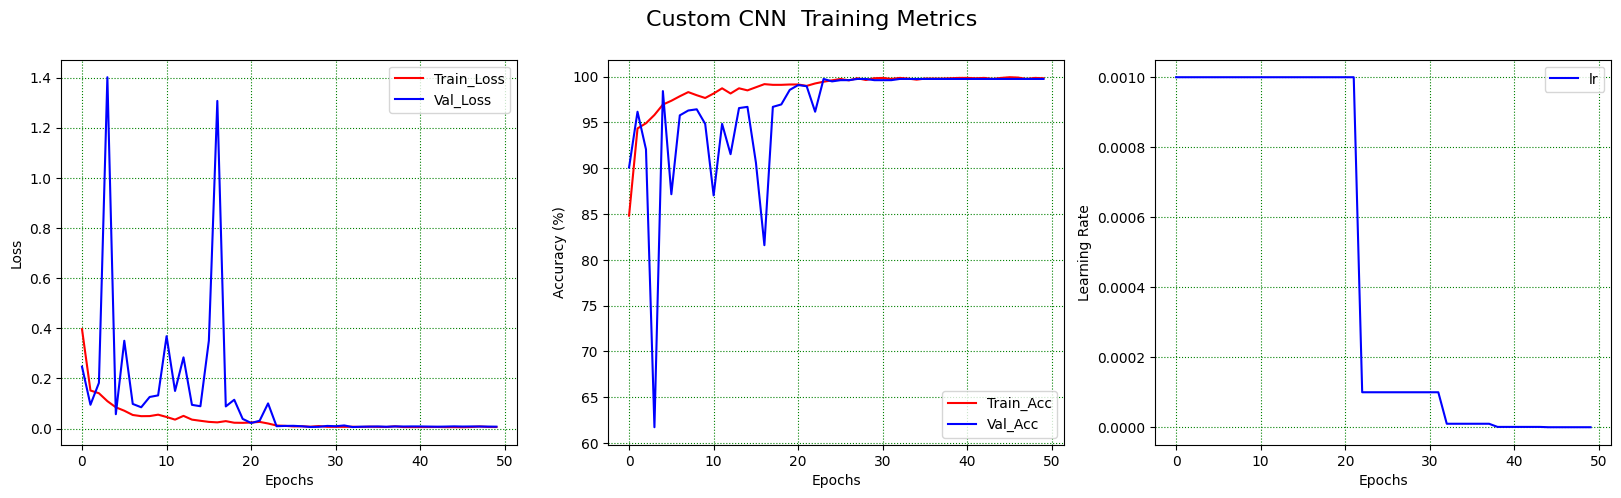

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

my_cnn.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
my_cnn.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
my_cnn.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Transfer Learning

In [24]:
transfer = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 192MB/s]


In [25]:
transfer.eval()

for params in model.parameters():
  params.requires_grad = False

In [26]:
num_ftrs = transfer.fc.in_features

transfer.fc = nn.Linear(num_ftrs, 3)

In [27]:
transfer = transfer.cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(transfer.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [28]:
transfer_df = fit(model=transfer, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=10, experiment_name="transfer")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Training Loss = 0.2219953, Training Accuracy = 92.029
Testing Loss = 2.0358297, Testing Accuracy = 70.199
New best accuracy: 70.199 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Loss = 0.0934389, Training Accuracy = 96.449
Testing Loss = 1.3654606, Testing Accuracy = 72.583
New best accuracy: 72.583 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Training Loss = 0.0469920, Training Accuracy = 98.451
Testing Loss = 0.1365880, Testing Accuracy = 95.629
New best accuracy: 95.629 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Training Loss = 0.0382001, Training Accuracy = 98.753
Testing Loss = 0.2831671, Testing Accuracy = 96.689
New best accuracy: 96.689 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Loss = 0.0661883, Training Accuracy = 98.262
Testing Loss = 0.7693876, Testing Accuracy = 86.358
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Loss = 0.0320060, Training Accuracy = 98.791
Testing Loss = 0.1766849, Testing Accuracy = 95.364
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Loss = 0.0393362, Training Accuracy = 98.980
Testing Loss = 1.8570385, Testing Accuracy = 82.517
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Loss = 0.0256854, Training Accuracy = 99.244
Testing Loss = 0.0319397, Testing Accuracy = 99.205
New best accuracy: 99.205 at epoch 8
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Loss = 0.0301674, Training Accuracy = 99.131
Testing Loss = 0.0275122, Testing Accuracy = 98.543
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Loss = 0.0093813, Training Accuracy = 99.773
Testing Loss = 0.0028644, Testing Accuracy = 100.000
New best accuracy: 100.000 at epoch 10
**************************************************



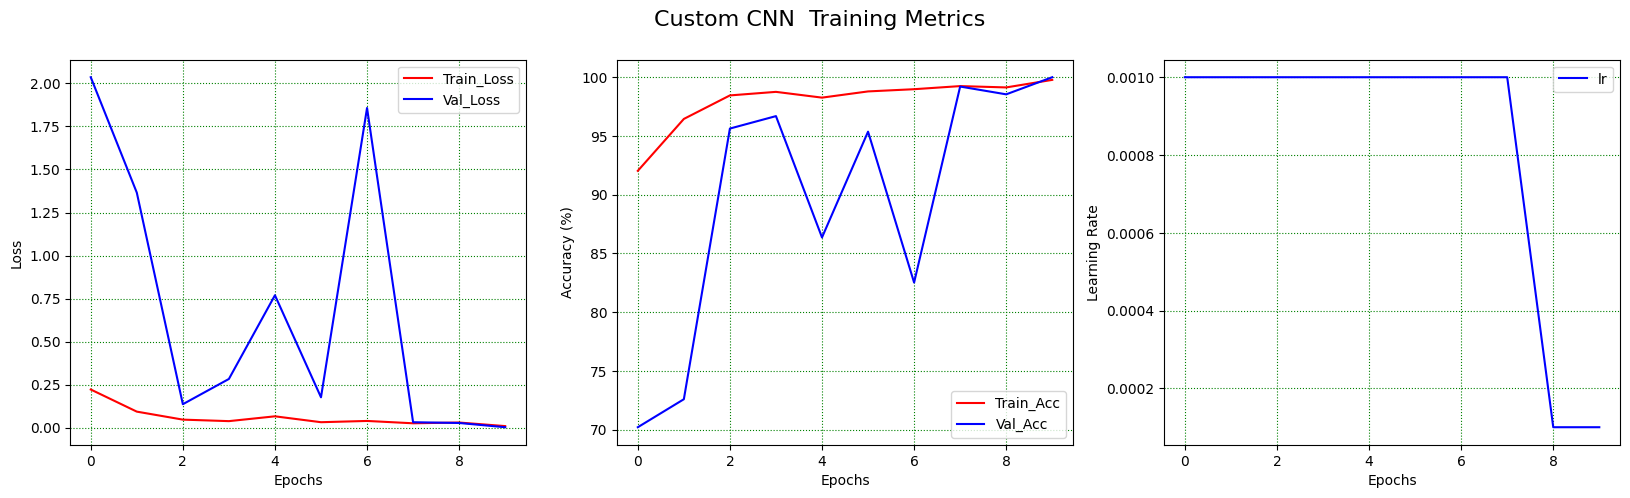

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

transfer_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
transfer_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
transfer_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Model Metrics

In [30]:
# Create the models first
fc_model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 100, 50, 20], num_classes=3)
custom_fcc = ResNet9()
transfer_model = transfer

# Then load the state dictionaries
fc_model.load_state_dict(torch.load("Models/fully_connected.pth"))
custom_fcc.load_state_dict(torch.load("Models/my_cnn.pth"))
transfer_model.load_state_dict(torch.load("Models/transfer.pth"))

model_list = [fc_model, custom_fcc, transfer_model]

In [31]:
def model_metrics(model, images, labels):

  with torch.no_grad():
    model, images = model.cuda(), images.cuda()
    pred_probs = model(images)
    preds = torch.argmax(pred_probs, axis=1)
    preds = preds.detach().cpu().numpy()

  precision = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  f1 = f1_score(labels, preds, average='weighted')
  accuracy = accuracy_score(labels, preds)

  return accuracy, precision, recall, f1

In [32]:
model_names = ["Fully Connected Net", "Custom CNN", "Transfer Model"]

In [33]:
precision_df = pd.DataFrame(np.empty([10, 3]),
                            index=np.arange(10),
                            columns=model_names)


recall_df = pd.DataFrame(np.empty([10, 3]),
                            index=np.arange(10),
                            columns=model_names)

accuracy_df = pd.DataFrame(np.empty([10, 3]),
                            index=np.arange(10),
                            columns=model_names)

f1_df = pd.DataFrame(np.empty([10, 3]),
                            index=np.arange(10),
                            columns=model_names)

In [34]:
def update_df(index):

  selected_model = model_list[index]
  limited_dataloader = islice(enumerate(test_dl), 10)


  for batch, (img, label) in tqdm(limited_dataloader, desc=f"Model {index}", total=10):

        (accuracy, precision, recall, f1) = model_metrics(selected_model, img, label)

        accuracy_df.iloc[batch, index] = accuracy
        precision_df.iloc[batch, index] = precision
        recall_df.iloc[batch, index] = recall
        f1_df.iloc[batch, index] = f1

In [35]:
for i in range(len(model_names)):
  update_df(i)

Model 0:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Model 0:  10%|█         | 1/10 [00:00<00:08,  1.05it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Model 0:  20%|██        | 2/10 [00:01<00:07,  1.02it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

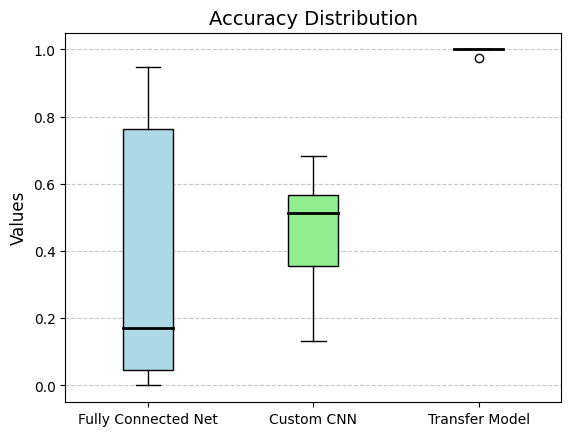

In [36]:
# Create the boxplot with patch_artist=True for coloring
box = plt.boxplot([accuracy_df[col] for col in accuracy_df.columns],
                  labels=accuracy_df.columns, patch_artist=True)

# Custom colors
colors = ['lightblue', 'lightgreen', 'lightpink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Style median lines
for median in box['medians']:
    median.set(color='black', linewidth=2)

# Add labels and title
plt.ylabel("Values", fontsize=12)
plt.title("Accuracy Distribution", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


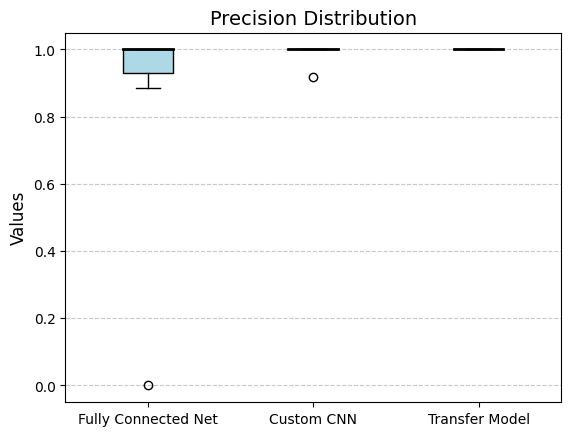

In [37]:
# Create the boxplot with patch_artist=True for coloring
box = plt.boxplot([precision_df[col] for col in precision_df.columns],
                  labels=precision_df.columns, patch_artist=True)

# Custom colors
colors = ['lightblue', 'lightgreen', 'lightpink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Style median lines
for median in box['medians']:
    median.set(color='black', linewidth=2)

# Add labels and title
plt.ylabel("Values", fontsize=12)
plt.title("Precision Distribution", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


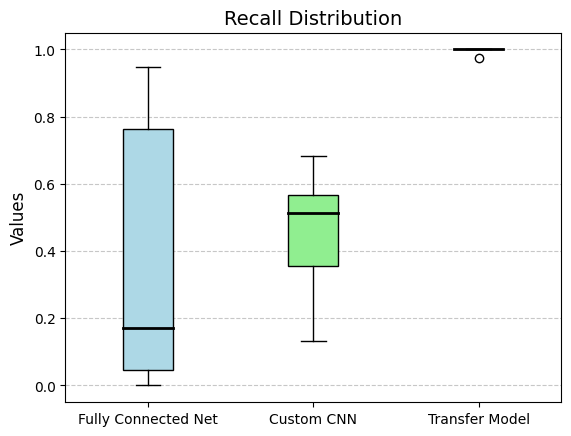

In [38]:
# Create the boxplot with patch_artist=True for coloring
box = plt.boxplot([recall_df[col] for col in recall_df.columns],
                  labels=recall_df.columns, patch_artist=True)

# Custom colors
colors = ['lightblue', 'lightgreen', 'lightpink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Style median lines
for median in box['medians']:
    median.set(color='black', linewidth=2)

# Add labels and title
plt.ylabel("Values", fontsize=12)
plt.title("Recall Distribution", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


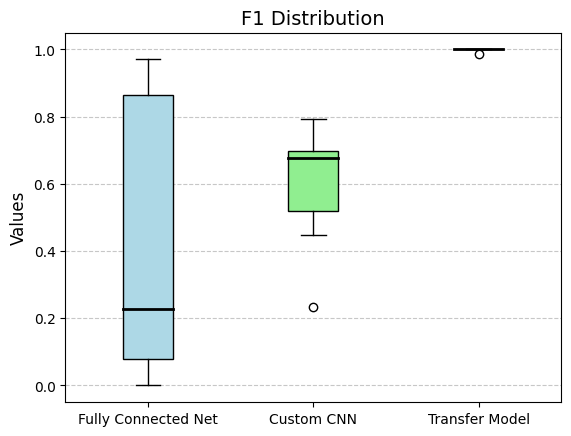

In [39]:
# Create the boxplot with patch_artist=True for coloring
box = plt.boxplot([f1_df[col] for col in f1_df.columns],
                  labels=f1_df.columns, patch_artist=True)

# Custom colors
colors = ['lightblue', 'lightgreen', 'lightpink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Style median lines
for median in box['medians']:
    median.set(color='black', linewidth=2)

# Add labels and title
plt.ylabel("Values", fontsize=12)
plt.title("F1 Distribution", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
